In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# %cd /content/gdrive/My Drive/HSE_DL_2021/01_week

In [1]:
from IPython import display

# Простейшие нейронные сети на PyTorch


Фрэймворком для обучения нейросеток на нашем курсе будет PyTorch. PyTorch стал очень популярным благодаря интуитивно понятной парадигме программирования нейронных сетей, основанной на динамическом графе. Не так давно PyTorch создал свою экосистему https://pytorch.org/ecosystem/, которая содержит в себе библиотеки, решающие практически всевозможные задачи машинного обучения. 

Чтобы установить библиотеку PyTorch, отправляйтесь в консоль и пропишите 

```
Для Windows без GPU
pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Для Windows c GPU
pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Для Linux без GPU
pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Для Linux c GPU
pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Для Mac
pip install torch torchvision

pip install pytorch-lightning
```


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Подгружаем pytorch 
import torch

print(torch.__version__)

1.11.0


In [4]:
# Подгрузим ещё немного пакетов :) 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

%matplotlib inline

## 1. О данных и бэйзлайнах

Наша главная цель - познакомиться с процессом создания простой нейронной сети и ее обучения.

__Делать всё это мы будем на животных.__ Ежегодно около 7.6 миллионов бедных животных в США оказываются в приютах. Часть из них находит себе новую семью, часть возвращается к старому (бывает, что питомец потерялся и его нашли на улице), а часть погибает. Ужегодно усыпляется около 2.7 млн. собак и кошек.  

Используя датасет с входной информацией (цвет, пол, возраст и т.п.) из одного из приютов, мы попытаемся спрогнозировать что произойдёт с новыми животными, которые попадут в этот приют. Данные, используемые в тетрадке уже были предварительно обработаны и приведены в удобную для построения моделей форму. 

In [5]:
import os

path = os.path.abspath(os.curdir)
X = pd.read_csv(path[:path.rfind('/')]+'/01_week/data/X_cat.csv', sep = '\t', index_col=0)
target = pd.read_csv(path[:path.rfind('/')]+'/01_week/data/y_cat.csv', sep = '\t', index_col=0, names=['status'])

print(X.shape)
X.head()

(26729, 37)


,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,...,1,0,0,0,0,0,0,0,0,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,...,0,1,0,0,0,0,0,1,0,0
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,...,1,0,0,0,0,0,0,1,0,0


In [6]:
target.iloc[:, :]

,status
0,Return_to_owner
1,Euthanasia
2,Adoption
3,Transfer
4,Transfer
...,...
26724,Transfer
26725,Transfer
26726,Adoption
26727,Transfer


В датасете находится около 27 тысяч наблюдений и 39 регрессоров. Посмотрим на то как выглядит распределение того, что произошло со зверятами по особям.

In [7]:
target.status.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: status, dtype: int64

Видим, что классы несбалансированы. Попробуем оставит четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [8]:
target = target.iloc[:, :]
target[target == 'Died'] = 'Euthanasia'

Закодируем классы.

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target)
y

array([2, 1, 0, ..., 0, 3, 3])

In [10]:
len(y)

26729

In [11]:
X.shape

(26729, 37)

Разобьём выборку на тренировочную и тестовую. 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(21383, 37)
(5346, 37)


Прежде, чем учить 228-слойных монстров, давайте построим какие-нибудь простые прогнозы, чтобы было с чем сравнить. Давайте построим наивный прогноз, а также обучим линейную регрессию и случайный лес.

### Константный прогноз

Построим константный прогноз, чтобы было с чем сравнивать и прогноз по какой-нибудь модели. 

In [13]:
y_train

array([3, 3, 1, ..., 3, 3, 3])

In [14]:
from sklearn.metrics import log_loss

# Определили статистические вероятности для всех категорий
## Фактически это распределение по классификационным группам в train и оно не меняется = E[X]
probas = np.array(pd.Series(y_train).value_counts(normalize=True).sort_index().tolist())
probas

array([0.40289015, 0.0655661 , 0.17906748, 0.35247627])

In [15]:
np.tile(probas, X_test.shape[0]).reshape(X_test.shape[0], 4)

array([[0.40289015, 0.0655661 , 0.17906748, 0.35247627],
       [0.40289015, 0.0655661 , 0.17906748, 0.35247627],
       [0.40289015, 0.0655661 , 0.17906748, 0.35247627],
       ...,
       [0.40289015, 0.0655661 , 0.17906748, 0.35247627],
       [0.40289015, 0.0655661 , 0.17906748, 0.35247627],
       [0.40289015, 0.0655661 , 0.17906748, 0.35247627]])

In [16]:
y_pred_const = np.tile(probas, X_test.shape[0]).reshape(X_test.shape[0], len(probas))

In [17]:
loss_const = log_loss(y_test, y_pred_const)
loss_const

1.2202552496487795

### Логистическая регрессия

In [18]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression( )
logreg.fit(X_train, y_train)
loss_logreg = log_loss(y_test, logreg.predict_proba(X_test))
loss_logreg

1.069060239402717

In [19]:
logreg.predict_proba(X_test) # 4 колонки, по одной на каждый класс

array([[0.18708353, 0.06705668, 0.04653767, 0.69932212],
       [0.71548116, 0.02923543, 0.10843331, 0.1468501 ],
       [0.52377075, 0.03810082, 0.18068288, 0.25744555],
       ...,
       [0.77510446, 0.01025016, 0.17601703, 0.03862835],
       [0.22847274, 0.05774503, 0.03826736, 0.67551488],
       [0.66540399, 0.03012324, 0.1208286 , 0.18364417]])

In [20]:
y_test, logreg.predict_proba(X_test)

(array([0, 2, 0, ..., 3, 0, 0]),
 array([[0.18708353, 0.06705668, 0.04653767, 0.69932212],
        [0.71548116, 0.02923543, 0.10843331, 0.1468501 ],
        [0.52377075, 0.03810082, 0.18068288, 0.25744555],
        ...,
        [0.77510446, 0.01025016, 0.17601703, 0.03862835],
        [0.22847274, 0.05774503, 0.03826736, 0.67551488],
        [0.66540399, 0.03012324, 0.1208286 , 0.18364417]]))

### Случайный лес 

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rf.fit(X_train, y_train)
loss_rf = log_loss(y_test, rf.predict_proba(X_test))
loss_rf

0.761389860365165

Неплохой результат. Попробуем улучшить его с помощью нейросеток. 

## 2. Собираем свою нейросеть

In [22]:
INPUT_SIZE = 37
HIDDEN_SIZE = 25
OUTPUT_SIZE = 4
LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 128

# Vanilla PyTorch

На первых порах лучше все писать самим. Для этого обратимся к первоисточнику, а именно к оригинальному PyTorch, с которого все началось. И для начала разберем все этапы работы с нейронной сети в упрощенной форме. 

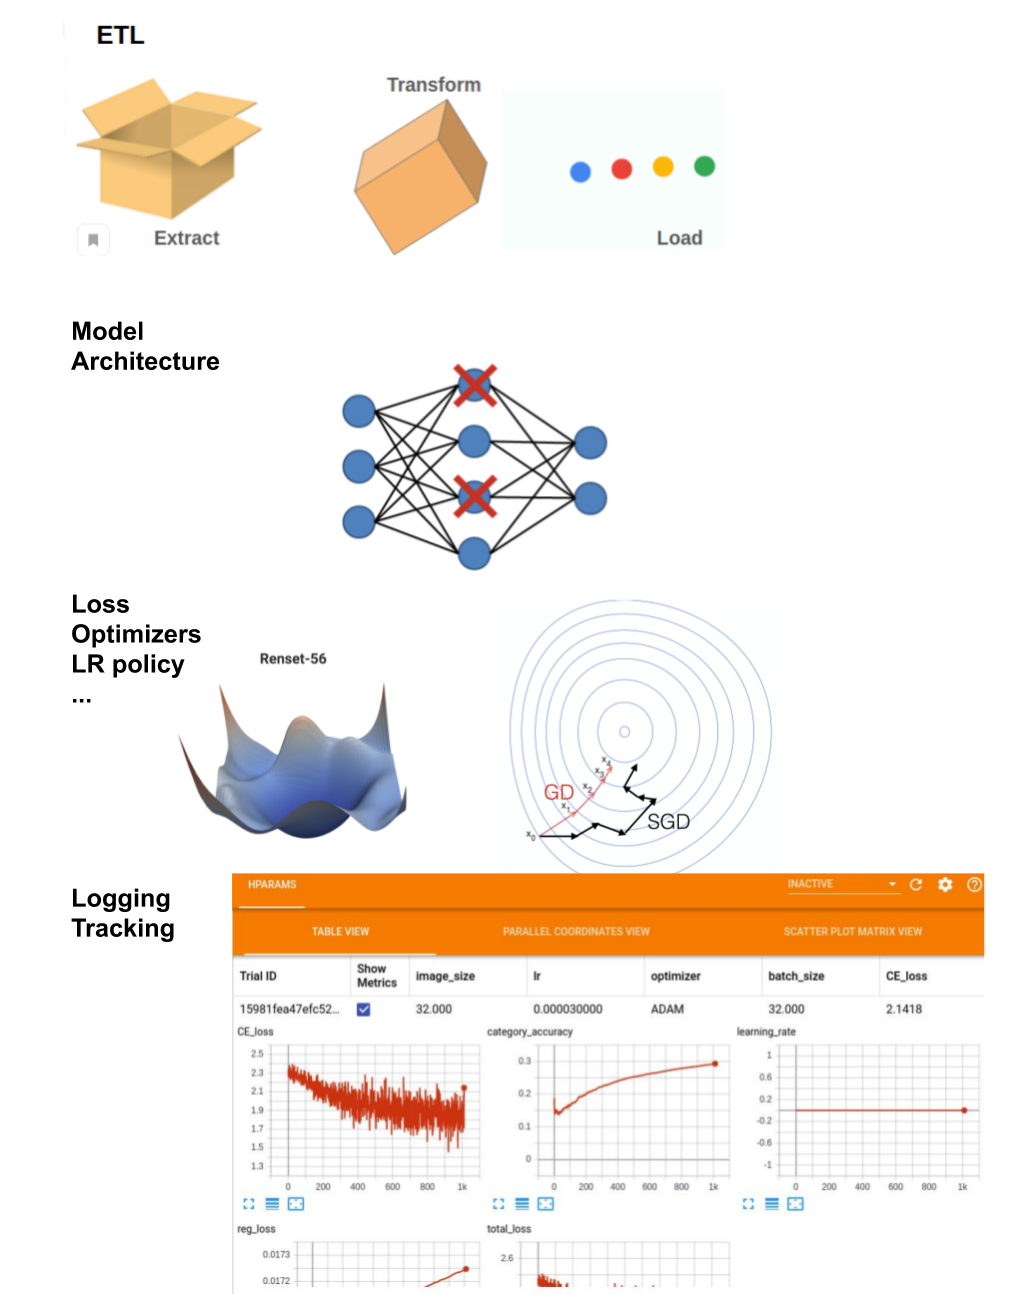

In [23]:
display.Image(path[:path.rfind('/')]+'/01_week/images/Pipeline.png')

In [24]:
# !pip install torchmetrics

In [25]:
import torch.nn as nn # содержит функции для реалзации архитектуры нейронных сетей
import torch.nn.functional as F # содержит различные функции активации и не только
import torch.optim as optim
import torch.utils.data as data_utils

from torchmetrics import Accuracy
from sklearn.preprocessing import StandardScaler

Для того чтобы подавать данные в нейронную сеть, создадим `DataLoader`, который предоставляет гибкий API для работы с входными данными.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :].values, y,
                                                    test_size=0.2, stratify=y, random_state=42)

In [27]:
pd.Series(y).value_counts()

0    10769
3     9422
2     4786
1     1752
dtype: int64

Создание __DataLoader__ для обучения сети

In [28]:
def create_data_loader(X_train, y_train, X_test, y_test):
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)
    return train_loader, test_loader

In [29]:
train_loader, test_loader = create_data_loader(X_train, y_train, X_test, y_test)

__Архитектура модели__

Архитектуру нейронной сети в PyTorch можно описать нескольками способами, в дальнейшем мы рассмотрим их более подробно. Сейчас предлагается сделать это используя `Sequential`.
`Sequential` -- это последовательный способ объявления каждой компоненты архитектуры нейронной сети.

In [30]:
def build_model():
    model = nn.Sequential(  
        # Добавляем в нашу модель первый слой из 25 нейронов
        nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE),
        nn.Sigmoid(),
        
        # Добавляем ещё один слой из 25 нейронов
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.Sigmoid(),
        
        # Выходной вектор на количество классов, получаем с помощью такого же линейного приеобразования,
        # как и предыдущие слои, но уже на нужное количество выходных нейронов (т.е. классов)
        nn.Linear(in_features=HIDDEN_SIZE, out_features=OUTPUT_SIZE),
        nn.Softmax()
    )

    return model

Функция `Linear` представляет собой полносвязный слой, где присутствуют обучаемая матрица и обучаемый баес.

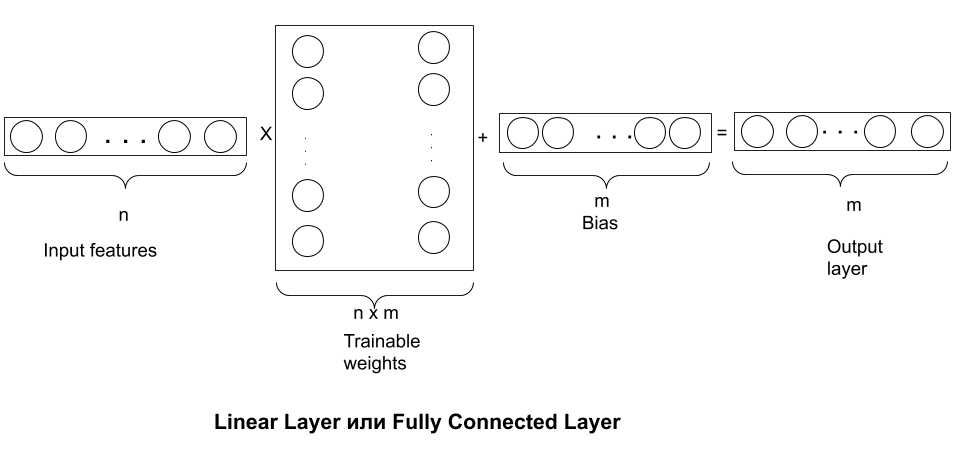

In [31]:
display.Image(path[:path.rfind('/')] + '/01_week/images/FClayer.png')

In [32]:
model = build_model()

In [33]:
print(model)

Sequential(
  (0): Linear(in_features=37, out_features=25, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=25, out_features=4, bias=True)
  (5): Softmax(dim=None)
)


На лекции была представлена возможная архитектура сети для задачи классификации. Сейчас мы тоже собрали свою сеть с одним скрытым слоем.

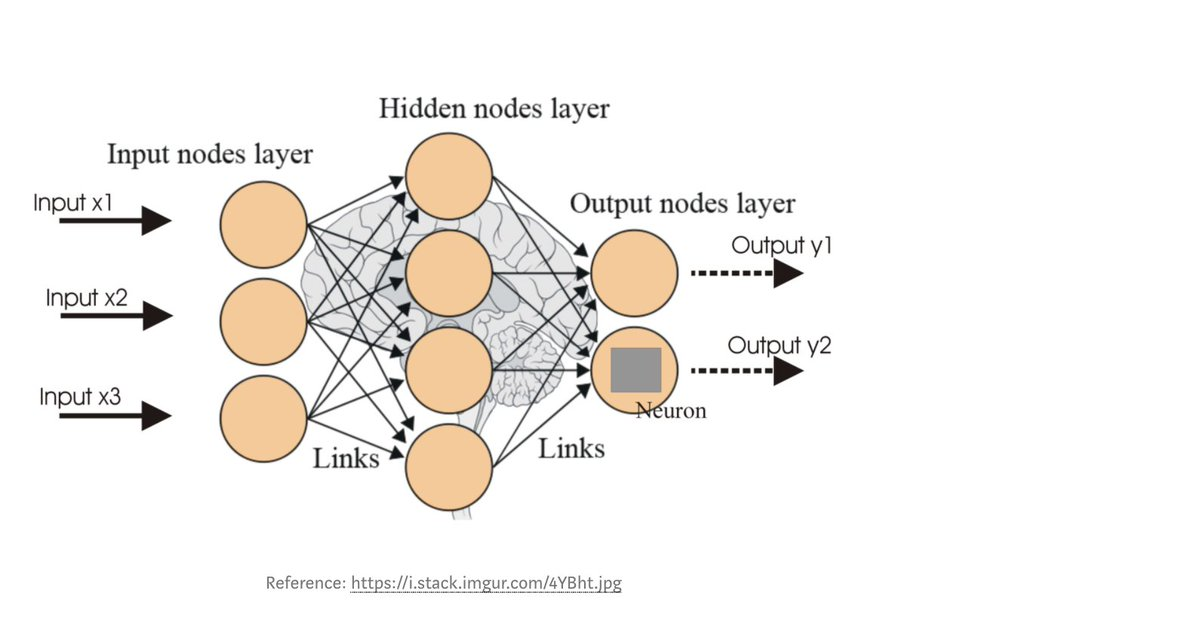

In [34]:
display.Image(path[:path.rfind('/')] + '/01_week/images/MLP2.jpg')

Обратите внимание, что последняя функция в в архитектуре сети -- это `Softmax`. Напомним, что `Softmax` используется для задачи классификации, чтобы получить значение увернности сети по каждому классу. Получается вектор на заданное количество классов, где наибольшее значение в какой-либо координате говорит о том, что сеть считает данный класс наиболее подходящим для данного наблюдения.

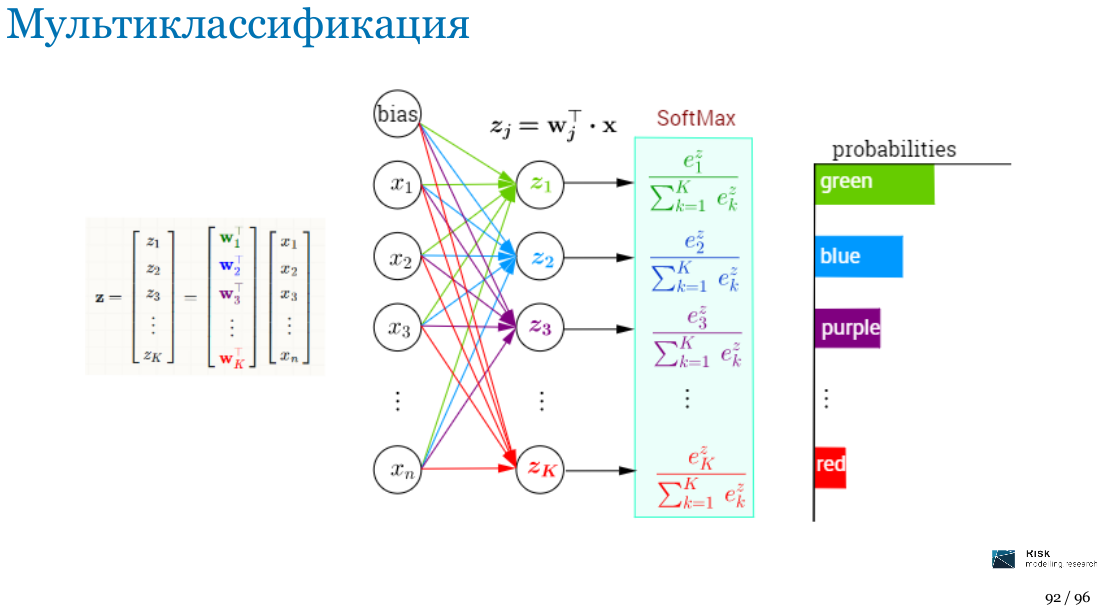

In [35]:
display.Image(path[:path.rfind('/')] + '/01_week/images/Softmax.png')

Отлично! Только что мы собрали свою первую нейросеть со скрытым слоем. Осталось ее обучить.

__Обучение модели__

Перед тем как обучать нашу нейросеть, нужно задать параметры обучения. 
- Во-первых, метод оптимизации. 
- Во-вторых, функцию потерь. 
- В-третьих, парочку метрик, на которые нам хотелось бы смотреть в процессе обучения.  

In [36]:
criterion = nn.CrossEntropyLoss()
accuracy = Accuracy()

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

Создадим массивы, куда будем складывать значение целевой функции на обучающей и валиационной выборках, а также точность.

Ниже представлен код __обучения__ сети. Нужно обратить внимание на несколько моментов:
1. Обучение ведется в течение нескольких эпох -- что значит несколько проходов по выборке.
2. `train_loader` позволяет итеративно проходится по выборке и на каждой итерации получать батч заранее заданного размера.
3. На каждом шаге обнуляем градиенты `optimizer.zero_grad()`, чтобы не накапливать их, тем самым неккоректно обновлять веса.
4. Вызывать явно `loss.backward()` для вычисления градиентов.
5. Вызывать явно `optimizer.step()` для обновления весов.

In [37]:
step = 0
train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy = []

def run_train():
    step = 0
    for epoch in range(EPOCHS):
        running_loss = []
        running_acc = []
        for features, label in train_loader:
            # Reset gradients
            optimizer.zero_grad()

            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label)
            loss.backward()
            acc = accuracy(output, label).item()

            # Update weights with gradients
            optimizer.step()

            running_loss.append(loss.item())
            running_acc.append(acc)

            step += 1

        train_loss_values.append(np.mean(running_loss))
        train_accuracy_values.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d : train_loss: %f' % (epoch, train_loss_values[-1]), (train_accuracy_values[-1]))
#             print(criterion(output, label), ' – ', accuracy(output, label))
#             print(f'\nLoss: {loss}\n')
#             print(f'Acc: {acc}\n')


        # Run validation
        running_loss = []
        running_acc = []
        for features, label in test_loader:
            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label)
            acc = accuracy(output, label).item()

            running_loss.append(loss.item())
            running_acc.append(acc)

        valid_loss_values.append(np.mean(running_loss))
        valid_accuracy.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d : valid_loss: %f' % (epoch, valid_loss_values[-1]), (valid_accuracy[-1]))
        
    return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy

In [38]:
train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy = run_train()

EPOCH 0 : train_loss: 1.395122 0.11162042945978187
EPOCH 0 : valid_loss: 1.391867 0.15140989422798157
EPOCH 20 : train_loss: 1.322262 0.4038384886724608
EPOCH 20 : valid_loss: 1.321813 0.40283345466568354
EPOCH 40 : train_loss: 1.306267 0.4014269770788295
EPOCH 40 : valid_loss: 1.305831 0.40283345466568354
EPOCH 60 : train_loss: 1.299093 0.40464232578164055
EPOCH 60 : valid_loss: 1.299612 0.40283345466568354
EPOCH 80 : train_loss: 1.296489 0.4022308142767066
EPOCH 80 : valid_loss: 1.296341 0.40283345466568354


 Посмотрим на динамику ошибки и значение точности нашей модели во времени.

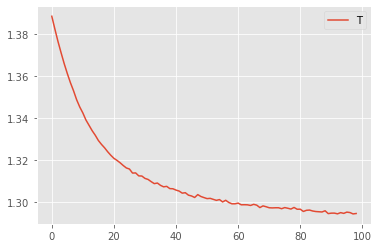

In [39]:
start = 1
plt.plot(train_loss_values[start:])
plt.legend('Train loss')

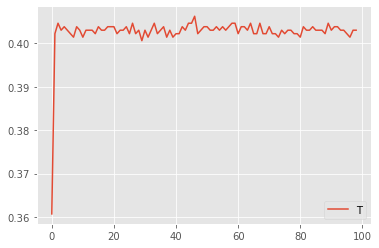

In [40]:
start = 1
plt.plot(train_accuracy_values[start:])
plt.legend('Train accuracy')

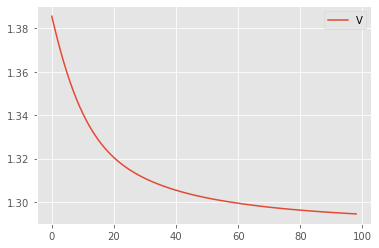

In [41]:
plt.plot(valid_loss_values[start:])
plt.legend('Validation loss')

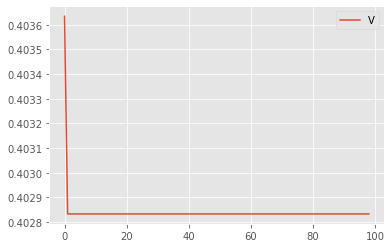

In [42]:
plt.plot(valid_accuracy[start:])
plt.legend('Validation accuracy')

Сохраним модель. Файл может иметь два расширения, как .pt, так и .pth. 

In [43]:
torch.save(model, 'simple_nn.pth')

Теперь загрузим сохраненную модель и посмотрим на ее предсказания. Важно! Когда идет этап inference модели, то нужно явно вызвать `model.eval()`, так как в случае если есть droupout или batch norm, то они не дложны работать как в процессе обучения, иначе они продолжат обучаться. 

In [44]:
model = torch.load('simple_nn.pth')
model.eval()

Sequential(
  (0): Linear(in_features=37, out_features=25, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=25, out_features=4, bias=True)
  (5): Softmax(dim=None)
)

In [45]:
# Выход модели (вероятность) на тестовой выборке
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.astype(np.float32)))
print(accuracy(test_scores, torch.tensor(y_test.astype(np.int))).item())
print(test_scores.numpy())

0.4029180705547333
[[0.56037676 0.02065006 0.03902137 0.37995172]
 [0.5603769  0.02065008 0.03902138 0.3799517 ]
 [0.56037676 0.02065006 0.03902137 0.37995172]
 ...
 [0.5603768  0.02065008 0.03902138 0.37995166]
 [0.56037676 0.02065006 0.03902137 0.3799518 ]
 [0.56037676 0.02065006 0.03902137 0.3799518 ]]


In [46]:
# Предсказание классов на тестовой выборке
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.astype(np.float32)))
predicted_classes = torch.argmax(test_scores, dim=1)
print(predicted_classes)

tensor([0, 0, 0,  ..., 0, 0, 0])


 Если `loss` еще падает, то точность не растет. __Как думаете, с чем это может быть связано?__

__Домашнее задание.__
Нужно обучить нейронную сеть, точность классификация должна быть не меньше __60%__. Как это можно получить:
1. Посмотрите на данные, характеристики.
2. Попробуйте менять гиперпараметры сети.
3. Обратите внимание на саму архитектуру сети.
4. Сделайте подсчет точности на валидационной выборке, не использую `torchmetrics`.

In [47]:
[(col, len(X[col].unique())) for col in X]

[('IsDog', 2),
 ('Age', 81),
 ('HasName', 2),
 ('NameLength', 12),
 ('NameFreq', 81),
 ('MixColor', 2),
 ('ColorFreqAsIs', 109),
 ('ColorFreqBase', 159),
 ('TabbyColor', 2),
 ('MixBreed', 2),
 ('Domestic', 2),
 ('Shorthair', 2),
 ('Longhair', 2),
 ('Year', 4),
 ('Month', 12),
 ('Day', 31),
 ('Hour', 869),
 ('Breed_Chihuahua Shorthair Mix', 2),
 ('Breed_Domestic Medium Hair Mix', 2),
 ('Breed_Domestic Shorthair Mix', 2),
 ('Breed_German Shepherd Mix', 2),
 ('Breed_Labrador Retriever Mix', 2),
 ('Breed_Pit Bull Mix', 2),
 ('Breed_Rare', 2),
 ('Sex_Female', 2),
 ('Sex_Male', 2),
 ('Sex_Unknown', 2),
 ('SexStatus_Flawed', 2),
 ('SexStatus_Intact', 2),
 ('SexStatus_Unknown', 2),
 ('Weekday_0', 2),
 ('Weekday_1', 2),
 ('Weekday_2', 2),
 ('Weekday_3', 2),
 ('Weekday_4', 2),
 ('Weekday_5', 2),
 ('Weekday_6', 2)]

**Комментарий**: в данных имеются категориальные фичи. Проведем сравнение работоспособоности простейшей нейронной сети при:
1. стандартизации некатегориальных переменных (данных в столбцах, имеющих также иные значения, а не только 0 или 1) и без их стандартизции;
2. использовании различных методов градиентного спуска;
3. изменении скорости обучения (learning rate).

In [48]:
# Split to train and  test
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :].values, y, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    stratify=y,
                                                    random_state=212)

# Scale data
def scale_data(df, cols_name):
    tmp_df = pd.DataFrame(data= df, columns= cols_name, copy=True)
    scaler = StandardScaler()
    nsc_cols = tmp_df.apply(lambda col: (len(col.unique()) <= 2) or (col.max() <= 1)).values
    tmp_df.loc[:, ~nsc_cols] = scaler.fit_transform(tmp_df.loc[:, ~nsc_cols])
    
    return tmp_df.values

X_train_scaled = scale_data(X_train, X.columns)
X_test_scaled = scale_data(X_test, X.columns)

# Hyperparameters
INPUT_SIZE = 37
HIDDEN_SIZE = 25
OUTPUT_SIZE = 4
LEARNING_RATES = [0.1, 0.01, 0.001, 0.0001]
EPOCHS = 100
BATCH_SIZE = 128

# Data loader
def create_data_loader(X_train, X_test, y_train, y_test):
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), 
                                            torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), 
                                           torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)
    return train_loader, test_loader

# Model
def build_my_model():
    my_model =  nn.Sequential(
        # Input layer
        nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE),
        nn.ReLU(),
        
        # Hidden layer
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.ReLU(),
        
        # Output layer
        nn.Linear(in_features=HIDDEN_SIZE, out_features=OUTPUT_SIZE),
        nn.Softmax()
    )
    
    return my_model

# Scores
my_criterion = nn.CrossEntropyLoss()

# Собственная функция подсчитывающая Accuracy
def my_acc(y_pred_prob, y_true):
    acc_res = (y_true == torch.argmax(y_pred_prob, dim= 1))
    acc_res = acc_res.float().mean()
    return acc_res

# Optimizers
opt_methods = ['SGD', 'Adam', 'Adagrad', 'Adadelta']

class Foo:
    def __init__(self, model, lr):
        self.model = model
        self.lr = lr
        
    def Adam(self):
        return optim.Adam(self.model.parameters(), lr= self.lr)
    
    def Adagrad(self):
        return optim.Adagrad(self.model.parameters(), lr= self.lr)
    
    def SGD(self):
        return optim.SGD(self.model.parameters(), lr= self.lr)
    
    def Adadelta(self):
        return optim.Adadelta(self.model.parameters(), lr= self.lr)

def call_method(f, opt_name):
    return getattr(f, opt_name)()

# Initialize model
def init_model(opt_name, LEARNING_RATE):
    my_model = build_my_model()
    f = Foo(model= my_model, lr=LEARNING_RATE)
    my_opt = call_method(f, opt_name=opt_name)
    
    return my_model, my_opt

# Run train
def my_run_train(sc_data):
    if sc_data == True:
        train_loader, test_loader = create_data_loader(X_train_scaled, X_test_scaled, y_train, y_test)
    else:
        train_loader, test_loader = create_data_loader(X_train, X_test, y_train, y_test)
    
    step = 0
    for epoch in range(EPOCHS):
        running_loss = []
        running_acc = []
        for features, label in train_loader:
            # Reset gradients
            my_opt.zero_grad()

            output = my_model(features)
            # Calculate error and backpropagate
            loss = my_criterion(output, label)
            loss.backward()
            acc = my_acc(output, label)

            # Update weights with gradients
            my_opt.step()

            running_loss.append(loss.item())
            running_acc.append(acc)

            step += 1

        train_loss_values.append(np.mean(running_loss))
        train_accuracy_values.append(np.mean(running_acc))
#         if epoch % 20 == 0:
#             print('EPOCH %d : train_loss: %f' % (epoch, train_loss_values[-1]))


        # Run validation
        running_loss = []
        running_acc = []
        for features, label in test_loader:
            output = my_model(features)
            # Calculate error and backpropagate
            loss = my_criterion(output, label)
            acc = my_acc(output, label)

            running_loss.append(loss.item())
            running_acc.append(acc)

        valid_loss_values.append(np.mean(running_loss))
        valid_accuracy.append(np.mean(running_acc))
#         if epoch % 20 == 0:
#             print('EPOCH %d : valid_loss: %f' % (epoch, valid_loss_values[-1]), (valid_accuracy[-1]))

        
    return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy

# Print results
def print_results(train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy,
                  opt_name, sc_data, lr):
    
    if sc_data == True:
        sc = 'scaled'
    else:
        sc = 'not scaled'
    
    start = 1
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,5), tight_layout=True)
    axs[0].plot(train_loss_values[start:])
    axs[0].set_title(f'Train loss – {opt_name} \n({sc} data), lr = {lr}.')
    axs[1].plot(train_accuracy_values[start:])
    axs[1].set_title(f'Train accuracy – {opt_name} \n({sc} data), lr = {lr}.')
    axs[2].plot(valid_loss_values[start:])
    axs[2].set_title(f'Validation loss – {opt_name} \n({sc} data), lr = {lr}.')
    axs[3].plot(valid_accuracy[start:])
    axs[3].set_title(f'Validation accuracy – {opt_name} \n({sc} data), lr = {lr}.')
    plt.show()

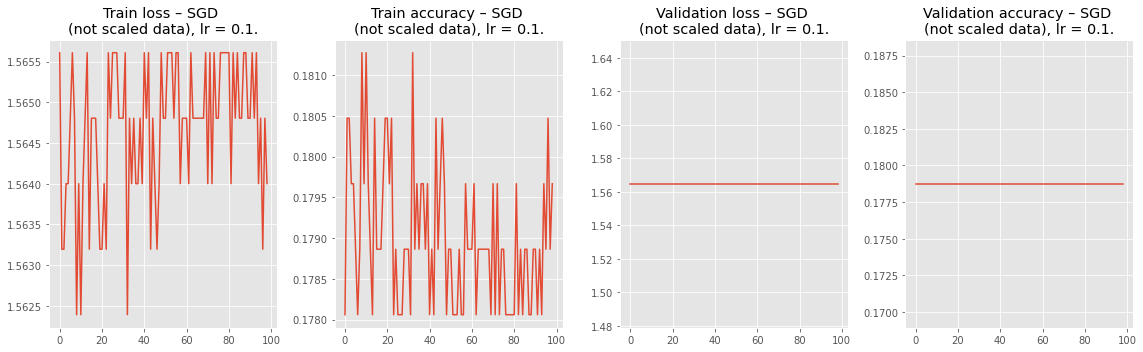

Точность на валидационной выборке составляет – 0.179012.
***************


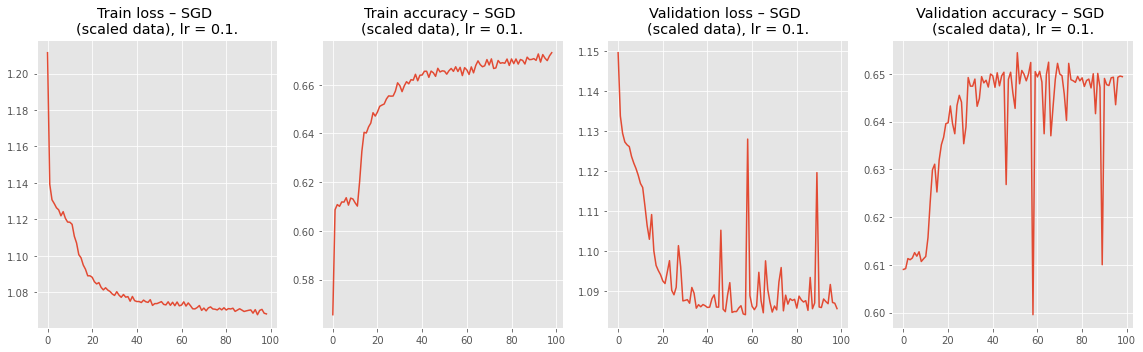

Точность на валидационной выборке составляет – 0.649458.
------------------------------


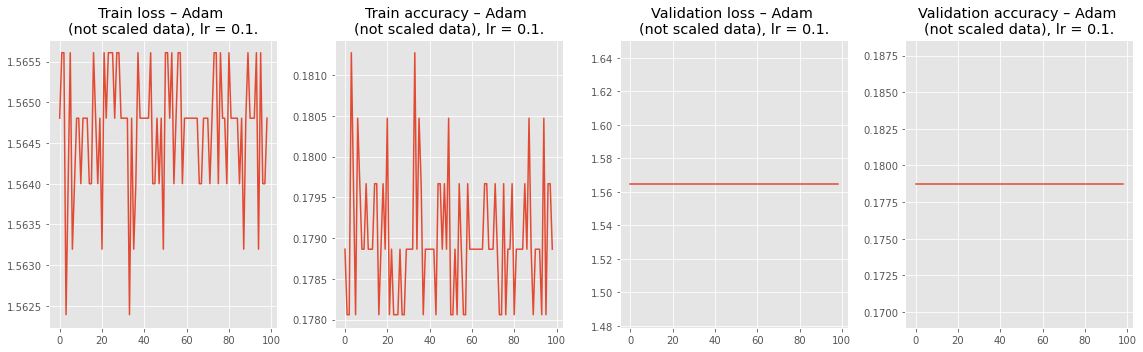

Точность на валидационной выборке составляет – 0.179012.
***************


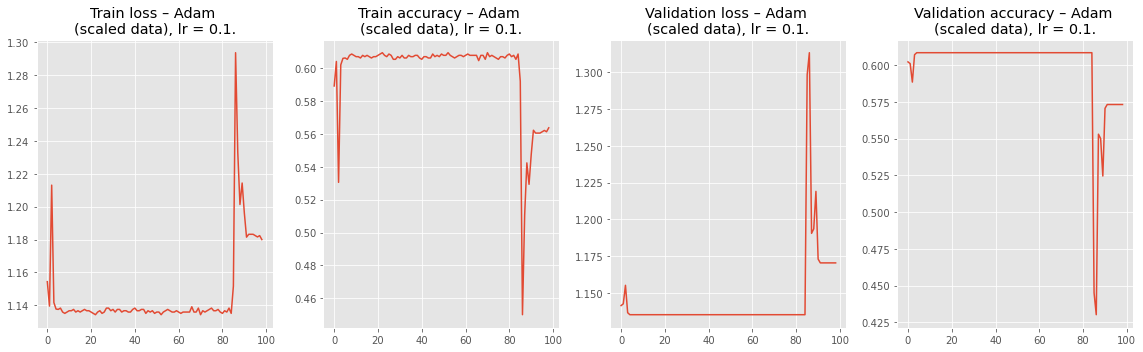

Точность на валидационной выборке составляет – 0.573326.
------------------------------


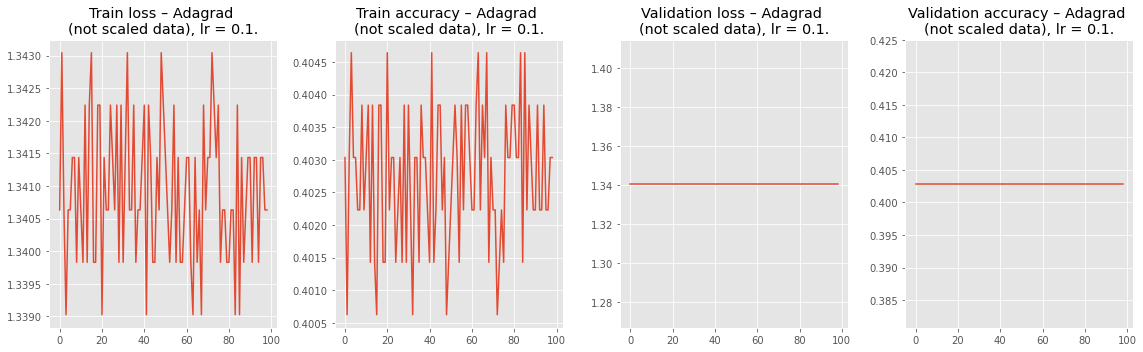

Точность на валидационной выборке составляет – 0.402918.
***************


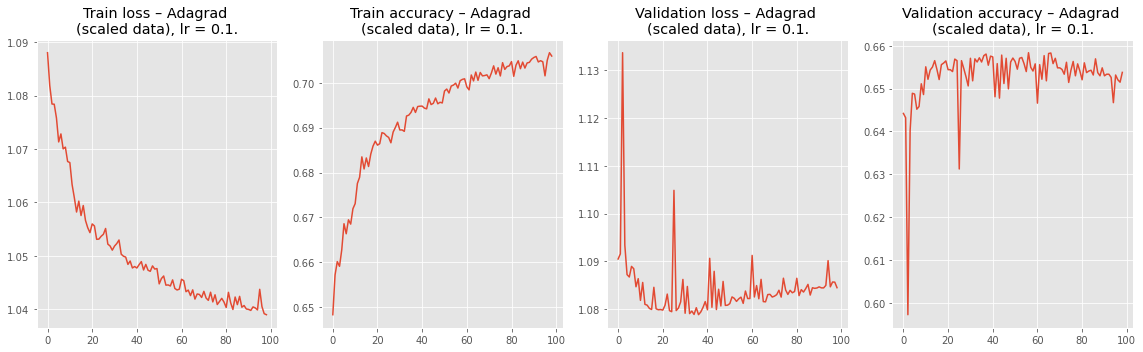

Точность на валидационной выборке составляет – 0.653573.
------------------------------


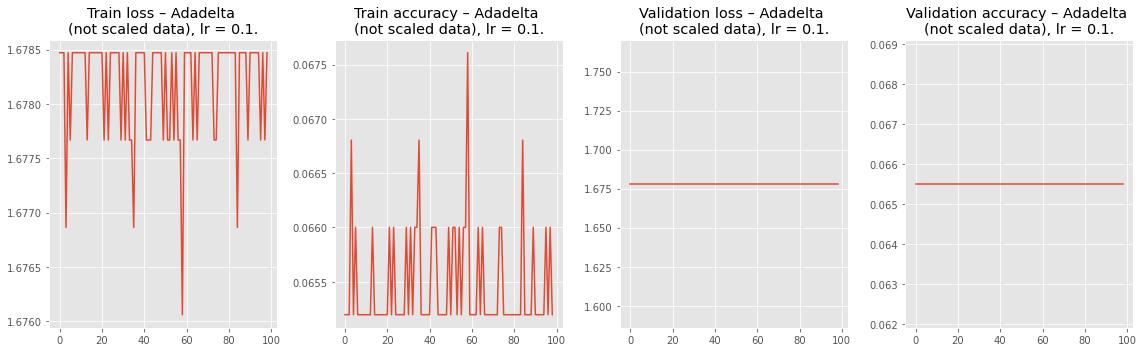

Точность на валидационной выборке составляет – 0.06547.
***************


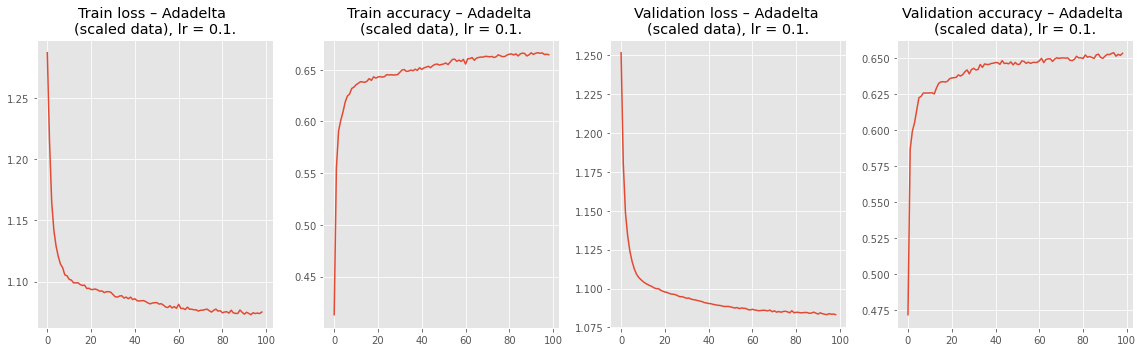

Точность на валидационной выборке составляет – 0.653199.


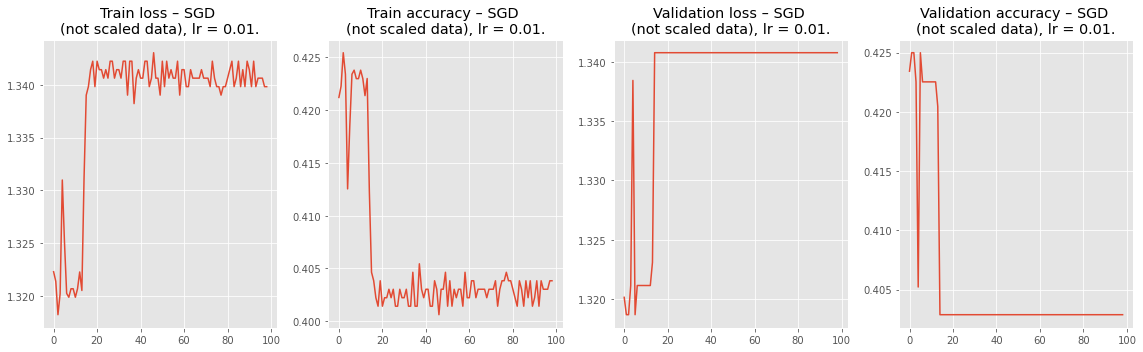

Точность на валидационной выборке составляет – 0.402918.
***************


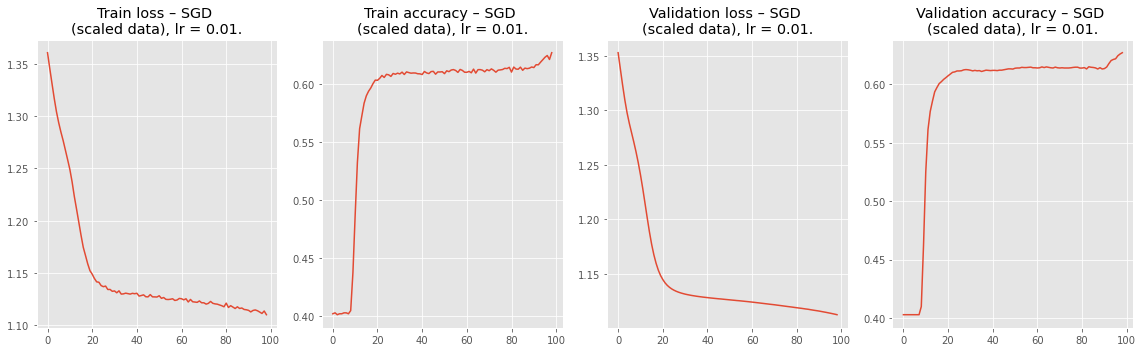

Точность на валидационной выборке составляет – 0.627385.
------------------------------


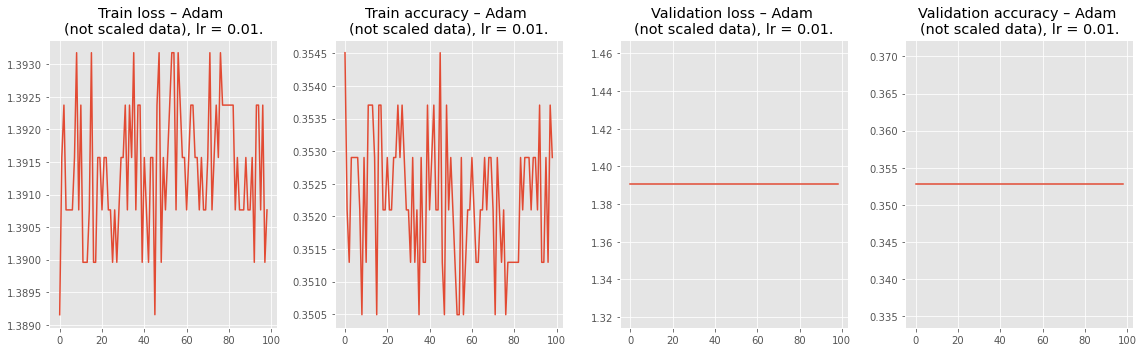

Точность на валидационной выборке составляет – 0.3526.
***************


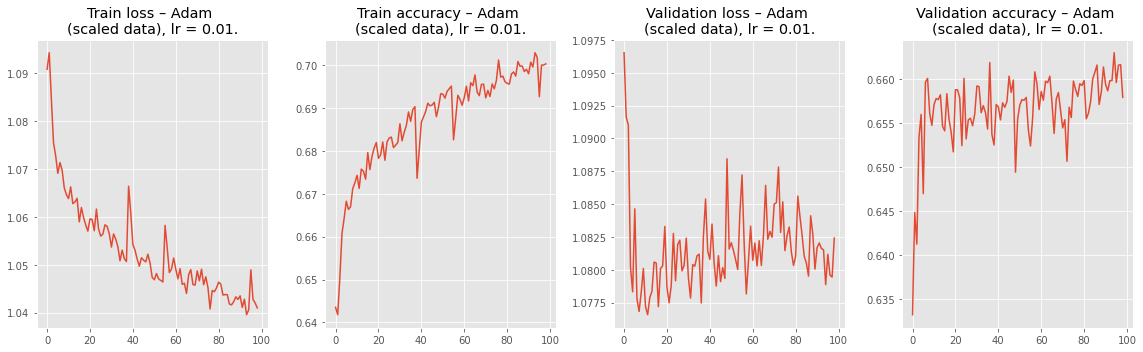

Точность на валидационной выборке составляет – 0.658062.
------------------------------


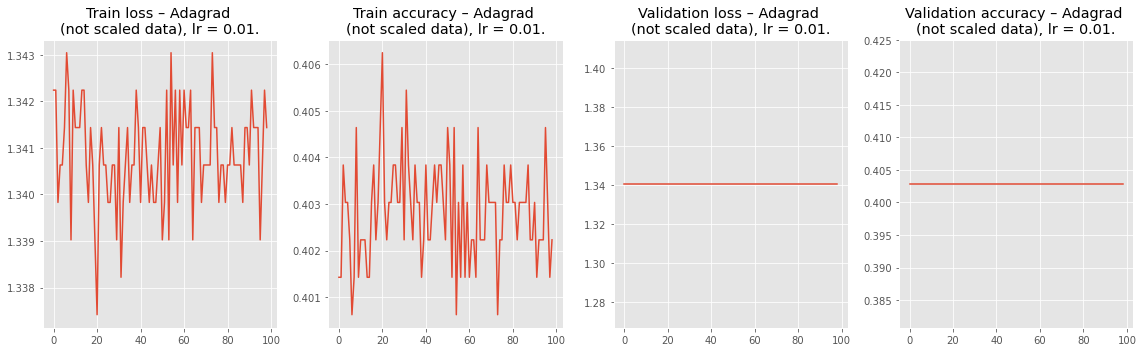

Точность на валидационной выборке составляет – 0.402918.
***************


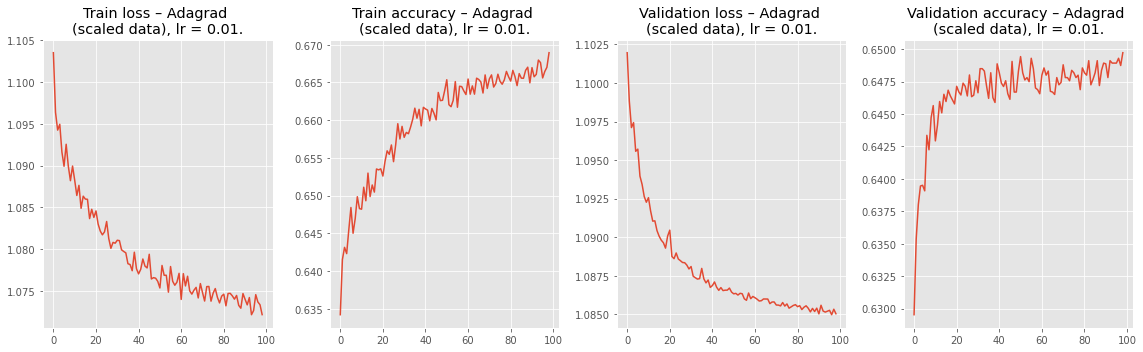

Точность на валидационной выборке составляет – 0.649645.
------------------------------


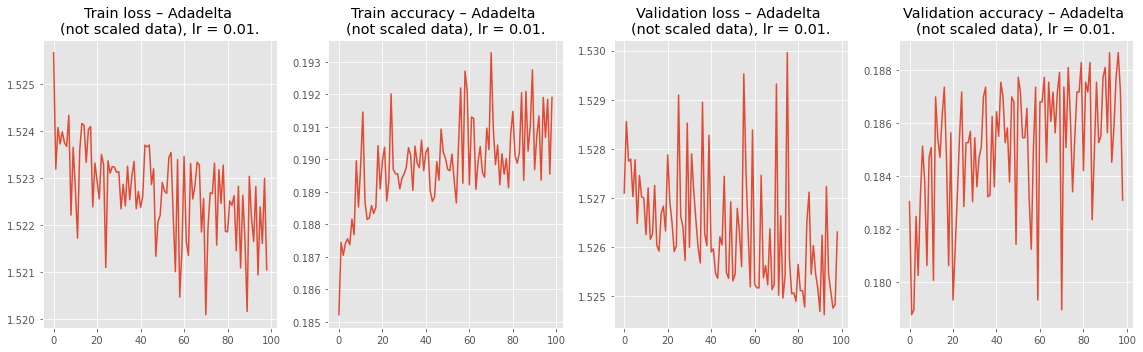

Точность на валидационной выборке составляет – 0.183315.
***************


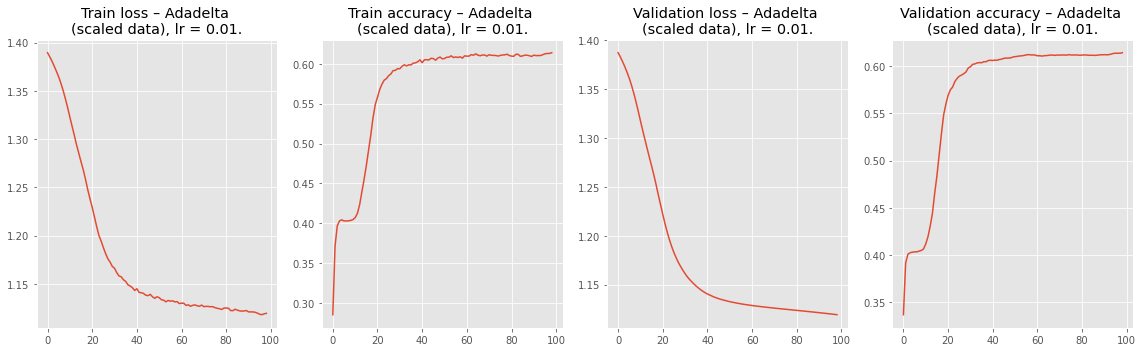

Точность на валидационной выборке составляет – 0.614104.


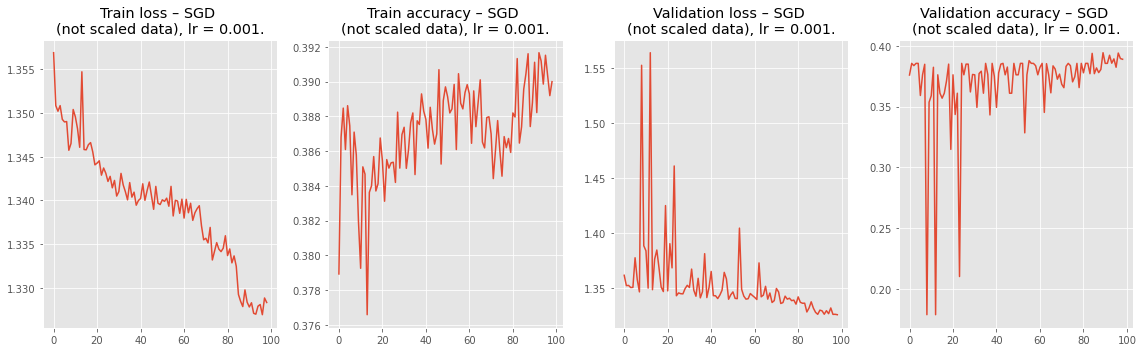

Точность на валидационной выборке составляет – 0.388889.
***************


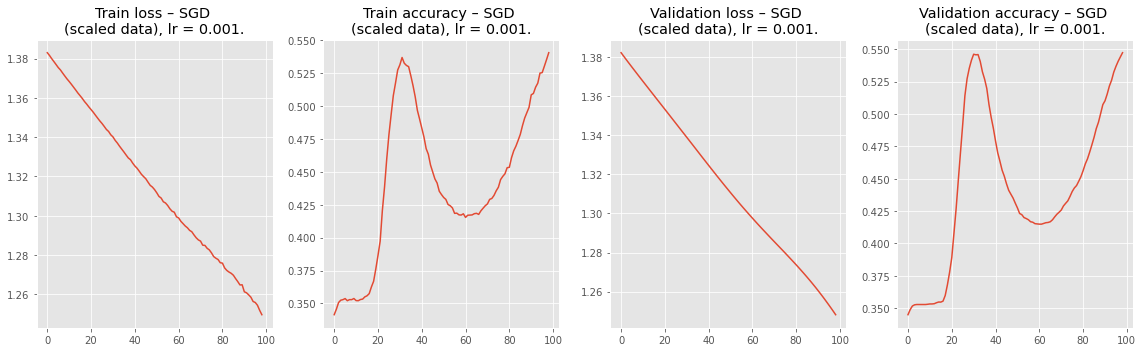

Точность на валидационной выборке составляет – 0.547512.
------------------------------


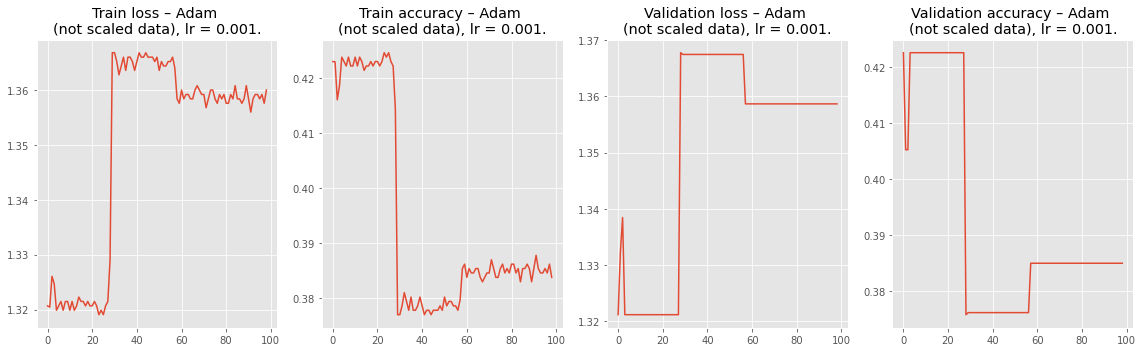

Точность на валидационной выборке составляет – 0.385148.
***************


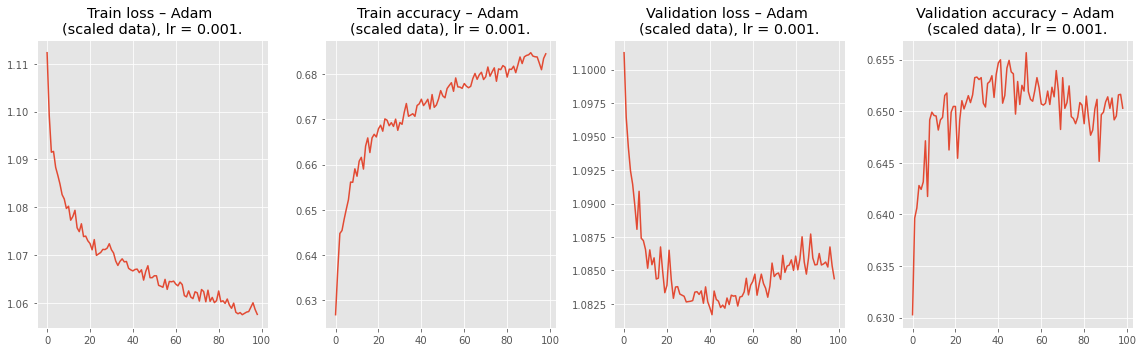

Точность на валидационной выборке составляет – 0.650393.
------------------------------


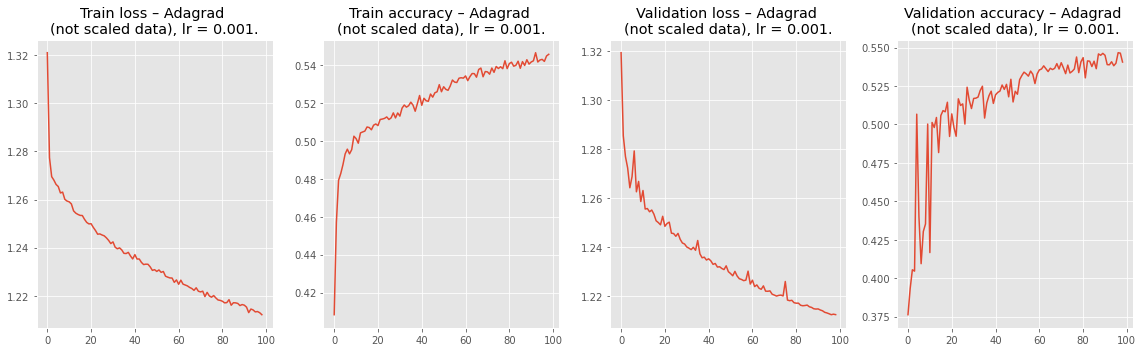

Точность на валидационной выборке составляет – 0.540591.
***************


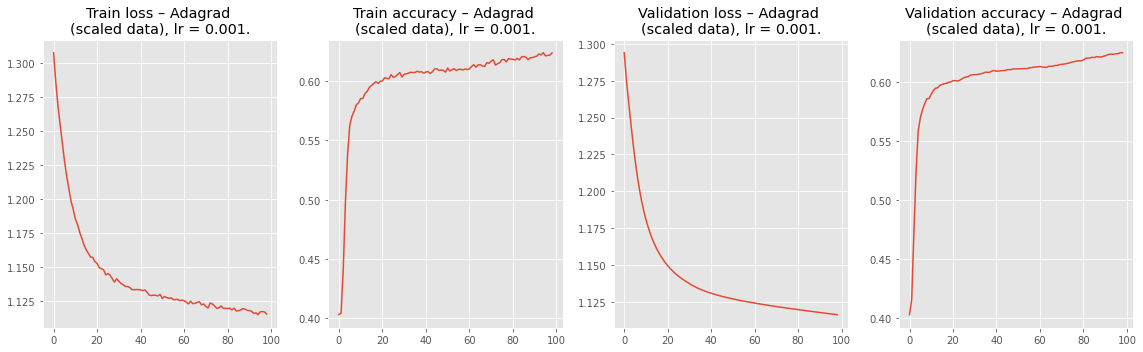

Точность на валидационной выборке составляет – 0.624953.
------------------------------


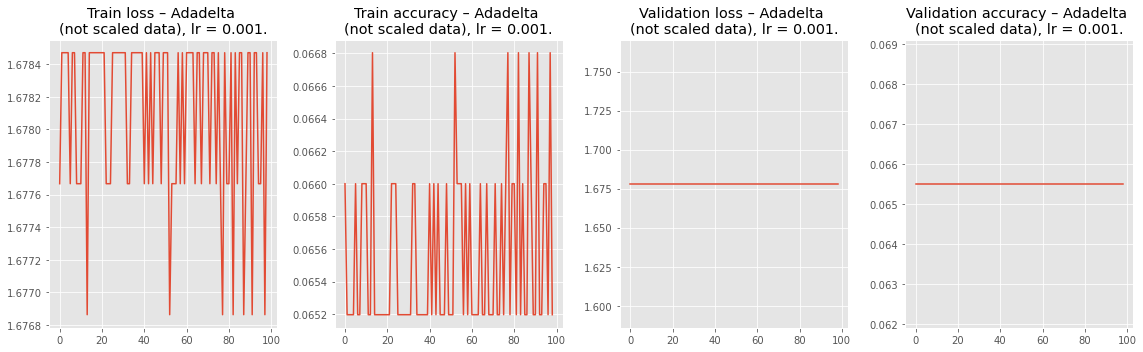

Точность на валидационной выборке составляет – 0.06547.
***************


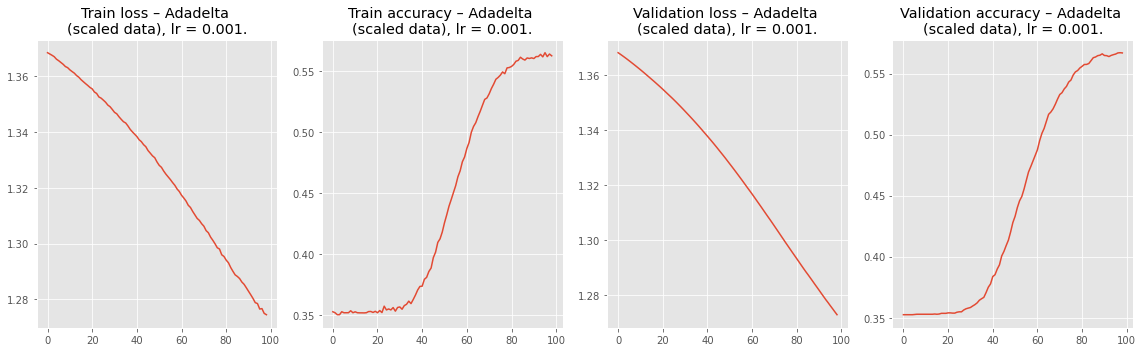

Точность на валидационной выборке составляет – 0.566966.


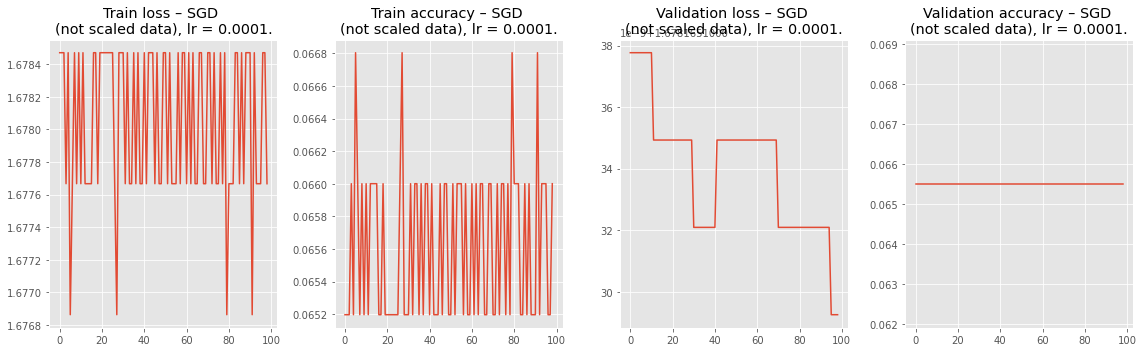

Точность на валидационной выборке составляет – 0.06547.
***************


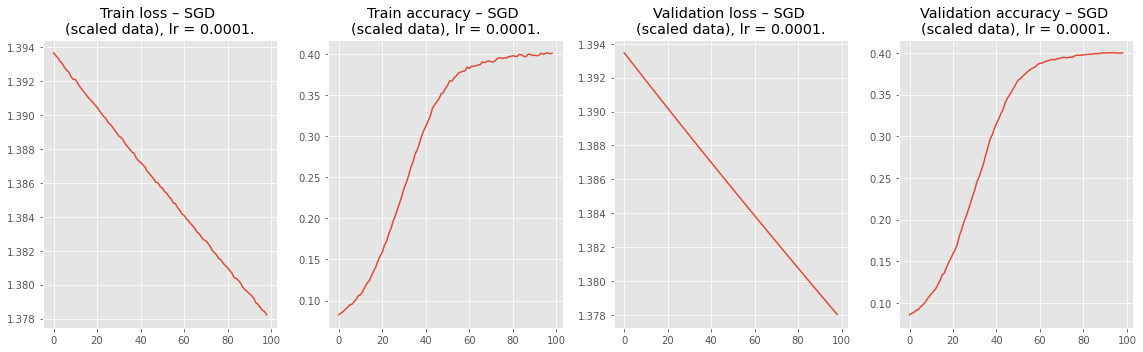

Точность на валидационной выборке составляет – 0.400112.
------------------------------


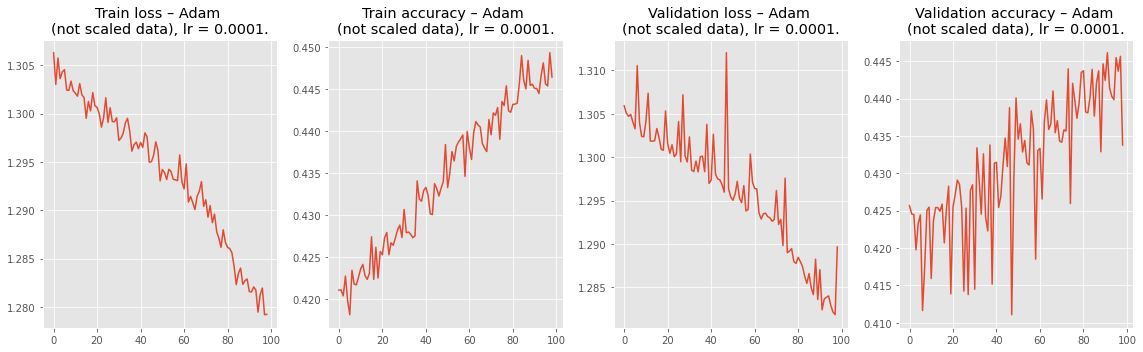

Точность на валидационной выборке составляет – 0.434156.
***************


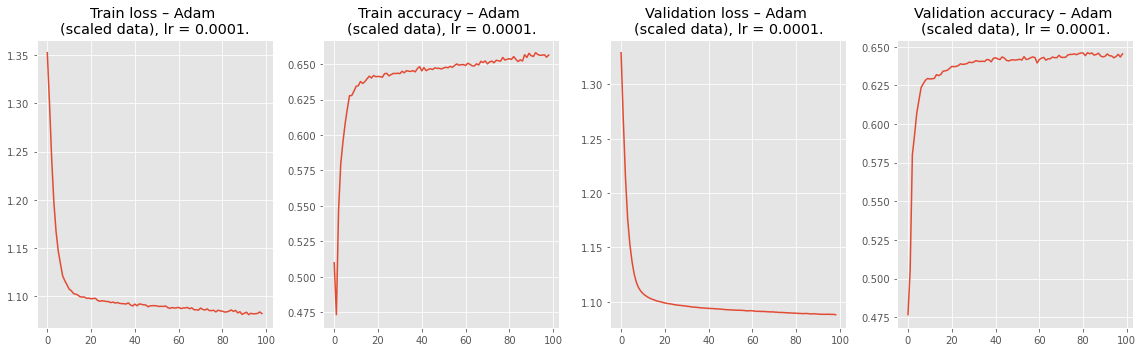

Точность на валидационной выборке составляет – 0.645529.
------------------------------


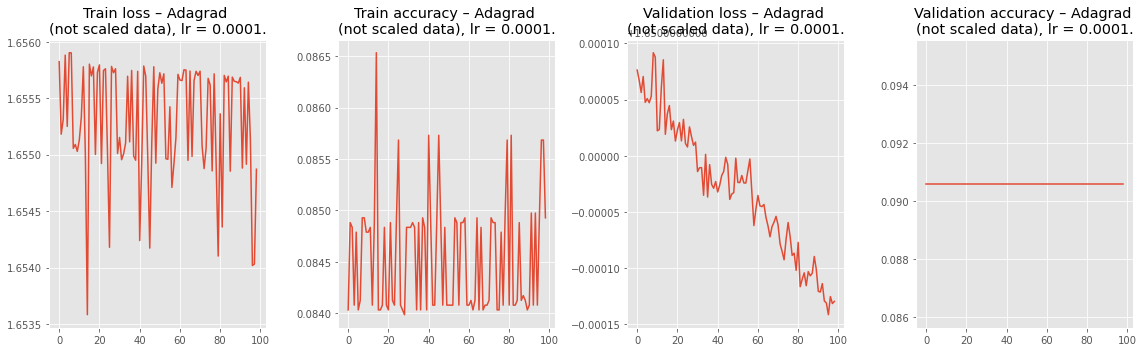

Точность на валидационной выборке составляет – 0.090535.
***************


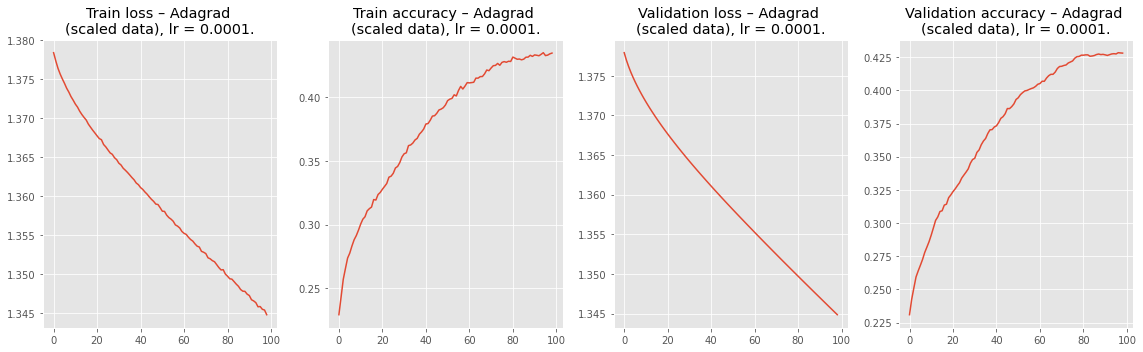

Точность на валидационной выборке составляет – 0.428358.
------------------------------


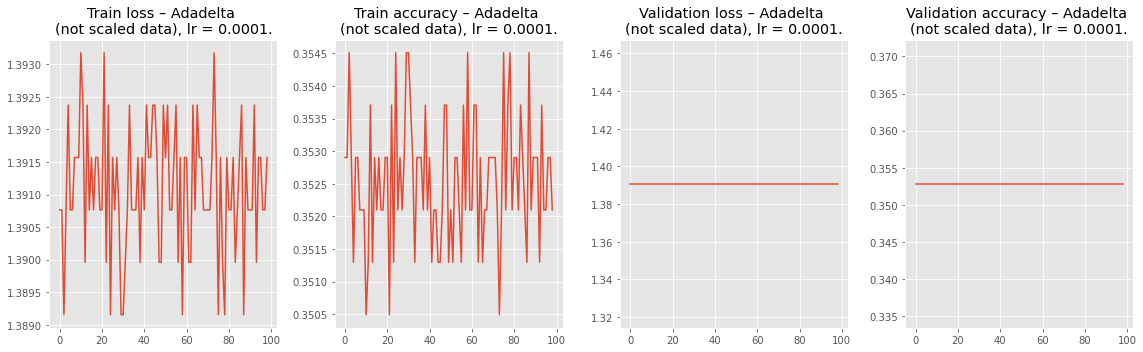

Точность на валидационной выборке составляет – 0.3526.
***************


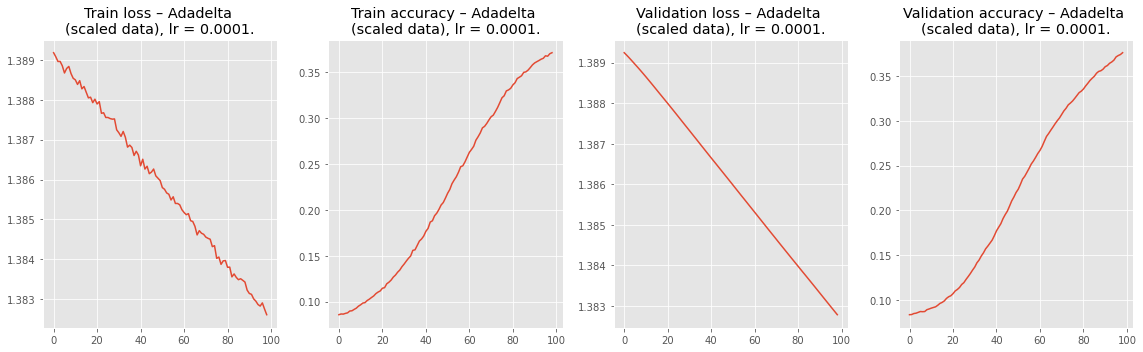

Точность на валидационной выборке составляет – 0.375982.


Максимальное значение, равное 0.658062, было достигнуто при следующих параметрах:
* метод градиентного спуска – Adam;
* скорость обучения (learning rate) – 0.01.


In [49]:
max_score = (None, 0, 0)

for lr in LEARNING_RATES:
    for opt_name in opt_methods:
        for sc_data in [False, True]: # выбор данных: False = не стандарт., True = стандарт.
            
            if sc_data:
                print('*' * 15)
                test_data = X_test_scaled
            else:
                test_data = X_test
        
            train_loss_values = []
            train_accuracy_values = []
            valid_loss_values = []
            valid_accuracy = []
        
            my_model, my_opt = init_model(opt_name, lr)
            train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy = my_run_train(sc_data)
            print_results(train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy, 
                          opt_name, sc_data, lr)
            
            test_scores = my_model(torch.tensor(test_data.astype(np.float32)))
            res_acc = round(float(my_acc(test_scores, torch.tensor(y_test.astype(np.float32)))), ndigits= 6)
            print(f'Точность на валидационной выборке составляет – {res_acc}.')
            
            if res_acc > max_score[1]:
                max_score = (opt_name, res_acc, lr)
        
        if opt_name != opt_methods[-1]: 
            print('-' * 30)
    
    print('=' * 50)

print(f'''\n\nМаксимальное значение, равное {max_score[1]}, было достигнуто при следующих параметрах:
* метод градиентного спуска – {max_score[0]};
* скорость обучения (learning rate) – {max_score[2]}.''')

**Вывод:**
1. Получить качество метрики Accuracy большее, чем при использовании алгоритма  случайного леса (RandomForest) не получилось;
2. Обучение нейронной сети сильно зависит от гиперпараметра скорости обучения (learning rate) и метода градиентного спуска;
3. Практически все использованные методы при стандартизации некатегориальных фич позволили показывать качество, близкое к указанному в задании (>0.6);
4. Наилучшее значение качества метрики Accuracy равняется 0.658062;
5. Так же не изменялся размер промежуточного слоя и размер батча.